In [11]:
# make imports from pa_lib possible (parent directory of file's directory)
import sys
from pathlib import Path

file_dir = Path.cwd()
parent_dir = file_dir.parent
sys.path.append(str(parent_dir))

%load_ext autoreload
%autoreload

import pandas as pd
import numpy as np

from collections import namedtuple

from pa_lib.file import (
    project_dir,
    load_bin,
    write_xlsx,
    store_bin,
)
from pa_lib.data import as_dtype, dtFactor, desc_col, lookup, clean_up_categoricals
from pa_lib.util import collect, value, flatten, normalize_rows, list_items
from pa_lib.log import time_log

# display long columns completely, show more rows
pd.set_option("display.max_colwidth", 300)
pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 200)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data

In [12]:
with project_dir("axinova"):
    ax_data = load_bin("ax_data.feather")
    ax_var_struct = load_bin("ax_var_struct.feather")

with time_log("merging code numbers to data"):
    ax_data["Label_Nr"] = lookup(
        target_df=ax_var_struct,
        target_col_name="Label_Nr",
        match_col=ax_data[["Variable", "Code"]],
        target_match_col_name=["Variable", "Label"],
    )

16:48:11 [INFO] Started loading binary file ...
16:48:11 [INFO] Reading from file C:\Users\kpf\data\axinova\ax_data.feather
16:48:11 [INFO] ... finished loading binary file in 0.23s (0.73s CPU)
16:48:11 [INFO] Started loading binary file ...
16:48:11 [INFO] Reading from file C:\Users\kpf\data\axinova\ax_var_struct.feather
16:48:11 [INFO] ... finished loading binary file in 0.0s (0.0s CPU)
16:48:11 [INFO] Started merging code numbers to data ...
16:48:27 [INFO] ... finished merging code numbers to data in 16.29s (16.3s CPU)


In [13]:
Variable = namedtuple("Variable", ["Label", "Codes", "Order"])

var_info = {}
for var, data in ax_var_struct.groupby("Variable"):
    var_info[var] = Variable(
        data["Variable_Label"].max(),
        data["Label"].to_list(),
        data["Label_Nr"].to_list(),
    )

## Variable/Code table for output

In [14]:
var_info_tab = pd.DataFrame.from_records(
    columns=["Variable", "Label", "Codes", "Order"],
    data=[
        (
            var,
            var_info[var].Label,
            ",".join(var_info[var].Codes),
            ",".join(map(str, var_info[var].Order)),
        )
        for var in var_info
    ],
    index="Variable",
)

In [5]:
with project_dir("axinova"):
    write_xlsx(var_info_tab, "variable_info.xlsx", sheet_name="Variables")

16:02:52 [INFO] Started storing xlsx file ...
16:02:52 [INFO] Writing to file C:\Users\kpf\data\axinova\variable_info.xlsx
16:02:52 [INFO] Written 11.2 KB
16:02:52 [INFO] ... finished storing xlsx file in 0.07s (0.05s CPU)


In [15]:
def var_label(variable):
    return var_info[variable].Label


def var_codes(variable):
    return var_info[variable].Codes

In [16]:
weekday_order = ax_data["DayOfWeek"].cat.categories.to_list()
workdays = weekday_order[:5]
weekend = weekday_order[5:]
ax_data["is_weekend"] = ax_data["DayOfWeek"].isin(weekend)

timeSlot_order = ax_data["TimeSlot"].cat.categories.to_list()
day = timeSlot_order[1:]
rush_hours = list_items(timeSlot_order, [1, 5])
day_no_rush = list_items(timeSlot_order, [2, 3, 4, 6])
ax_data["is_day"] = ax_data["TimeSlot"].isin(day)
ax_data["is_rush"] = ax_data["TimeSlot"].isin(rush_hours)
ax_data["is_day_no_rush"] = ax_data["TimeSlot"].isin(day_no_rush)

ax_data.loc[ax_data["is_rush"], "TimeSlot_cat"] = "Day: Rush Hours"
ax_data.loc[ax_data["is_day_no_rush"], "TimeSlot_cat"] = "Day: no Rush Hours"
ax_data["TimeSlot_cat"].fillna("Night", inplace=True)

stations_d = [
    "Aarau",
    "Basel SBB",
    "Bern",
    "Biel/Bienne",
    "Brig",
    "Chur",
    "Luzern",
    "Olten",
    "St. Gallen",
    "Winterthur",
    "Zug",
    "Zürich Enge",
    "Zürich Flughafen",
    "Zürich Flughafen - Airside",
    "Zürich Flughafen - Landside",
    "Zürich HB",
    "Zürich Hardbrücke",
    "Zürich Oerlikon",
    "Zürich Stadelhofen",
]
stations_f = [
    "Biel/Bienne",
    "Fribourg",
    "Genève Aéroport",
    "Genève Cornavin",
    "Lausanne",
    "M2",
    "Neuchatel",
]
stations_i = ["Bellinzona", "Lugano"]
ax_data.loc[ax_data["Station"].isin(stations_f), "StationSprache"] = "Französisch"
ax_data.loc[ax_data["Station"].isin(stations_i), "StationSprache"] = "Italienisch"
ax_data.loc[ax_data["Station"].isin(stations_d), "StationSprache"] = "Deutsch"

ax_data = as_dtype(ax_data, dtFactor, incl_dtype=["bool", "object"])

In [17]:
with value(ax_data["DayOfWeek"].isin(weekend)) as weekend_rows:
    ax_data_weekends = (
        ax_data.loc[weekend_rows].pipe(clean_up_categoricals).reset_index(drop=True)
    )
    ax_data_workdays = (
        ax_data.loc[~weekend_rows].pipe(clean_up_categoricals).reset_index(drop=True)
    )

In [18]:
desc_col(ax_data, det=True)

,DTYPE,NULLS,UNIQUE,MEM,RANGE
Station,category,0/9180072,27,8.8 MB,"[Aarau,Zürich Stadelhofen]"
DayOfWeek,category,0/9180072,7,8.8 MB,"[Monday,Sunday]"
Time,category,0/9180072,96,8.8 MB,"[00:00 - 00:15,23:45 - 00:00]"
Variable,category,0/9180072,117,8.8 MB,"[g_220,nat_ausland]"
Code,category,0/9180072,156,17.5 MB,"[1 - 4 Flüge,Über den lokalen TV-Kabelanbieter (nicht Cablecom)]"
Value,float64,0/9180072,495186,70.0 MB,"[0.47903999999999997,58.059993773]"
Year,category,0/9180072,1,8.8 MB,"[2019,2019]"
Month,category,0/9180072,6,8.8 MB,"[05,10]"
logValue,float64,0/9180072,495186,70.0 MB,"[-0.7359711777508736,4.0614768513453585]"
VarDesc,category,0/9180072,117,8.8 MB,"[Abteilungs-/Teamleitung,kein Mobiltelefon]"


In [ ]:
desc_col(ax_data_workdays, det=True)

In [ ]:
desc_col(ax_data_weekends, det=True)

### Write out enriched data

In [10]:
with project_dir("axinova"):
    store_bin(ax_data, "ax_data_enriched.feather")

16:03:12 [INFO] Started storing feather file ...
16:03:12 [INFO] Writing to file C:\Users\kpf\data\axinova\ax_data_enriched.feather
16:03:13 [INFO] Written 323.9 MB
16:03:13 [INFO] ... finished storing feather file in 0.54s (0.67s CPU)


## Select data by any column(s)

In [21]:
def _check_selection(data, selection, allowed_columns):
    allowed_values = {}
    for column in allowed_columns:
        allowed_values[column] = data[column].cat.categories
    if set(selection.keys()) - set(allowed_columns) != set():
        raise NameError(f"Unknown column name in selection: {selection.keys()}")
    clean_selection = {}
    for column in allowed_columns:
        if column in selection:
            col_values = list(flatten(selection[column]))
            if set(col_values) - set(allowed_values[column]) != set():
                raise ValueError(
                    f"Illegal value(s) in parameter {column}: {col_values}"
                )
            clean_selection[column] = col_values
        else:
            clean_selection[column] = None
    return clean_selection


def select_data(all_data, **selection):
    select_columns = "DayOfWeek Station Variable Month TimeSlot Hour Time TimeSlot_cat StationSprache".split()
    selection = _check_selection(all_data, selection, allowed_columns=select_columns)
    row_mask = pd.Series([True] * all_data.shape[0])
    for col in select_columns:
        if selection[col] is not None:
            row_mask &= all_data[col].isin(selection[col])
    return all_data.loc[row_mask].pipe(clean_up_categoricals).reset_index(drop=True)

# Check distributions

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

## Time

In [ ]:
fig, (ax_weekend, ax_workdays) = plt.subplots(
    nrows=1, ncols=2, sharey="all", figsize=(30, 12)
)
plt.tight_layout()
sns.barplot(
    data=ax_data_weekends.eval("Value = Value / 2"),  # average weekend day
    x="Time",
    y="Value",
    ci=None,
    estimator=np.sum,
    ax=ax_weekend,
)
sns.barplot(
    data=ax_data_workdays.eval("Value = Value / 5"),  # average workday
    x="Time",
    y="Value",
    ci=None,
    estimator=np.sum,
    ax=ax_workdays,
)
fig.autofmt_xdate(rotation=90, ha="left")

### Time by Weekday

In [ ]:
sns.catplot(
    data=ax_data,
    kind="bar",
    x="Time",
    y="Value",
    row="DayOfWeek",
    row_order=weekday_order,
    ci=None,
    estimator=np.sum,
    height=6,
    aspect=2,
)

## Hours

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

fig, (ax_weekend, ax_workdays) = plt.subplots(
    nrows=2, ncols=1, sharey="all", figsize=(16, 20)
)
plt.tight_layout()
sns.barplot(
    data=ax_data_workdays.eval("Value = Value / 5"),  # average workday
    x="Hour",
    y="Value",
    estimator=np.sum,
    ci=None,
    ax=ax_workdays,
)
sns.barplot(
    data=ax_data_weekends.eval("Value = Value / 2"),  # average weekend day
    x="Hour",
    y="Value",
    estimator=np.sum,
    ci=None,
    ax=ax_weekend,
)

## Time Slots

In [ ]:
ax_data["TimeSlot"].value_counts()

### Plot sum(value) per time slot, scaled to one day

In [ ]:
fig, (ax_weekend, ax_workdays) = plt.subplots(
    nrows=1, ncols=2, sharey="all", figsize=(16, 6)
)
plt.tight_layout()
sns.barplot(
    data=ax_data_weekends.eval("Value = Value / 2"),
    x="TimeSlot",
    y="Value",
    estimator=np.sum,
    ci=None,
    ax=ax_weekend,
)
sns.barplot(
    data=ax_data_workdays.eval("Value = Value / 5"),
    x="TimeSlot",
    y="Value",
    estimator=np.sum,
    ci=None,
    ax=ax_workdays,
)

In [ ]:
ax_data.groupby("TimeSlot").agg({"Hour": collect})

## Stations

In [ ]:
ax_data.Station.value_counts()

In [ ]:
plt.figure(figsize=(10, 6))
plt.xticks(rotation=90)

sns.barplot(data=ax_data, x="Station", y="Value", ci=None, estimator=np.sum)

In [ ]:
plt.figure(figsize=(16, 10))
plt.xticks(rotation=90)

sns.boxenplot(data=ax_data, x="Station", y="Value")

## Weekdays

In [ ]:
ax_data.DayOfWeek.value_counts()

In [ ]:
plt.figure(figsize=(10, 6))

sns.barplot(
    data=ax_data,
    x="DayOfWeek",
    y="Value",
    ci="sd",
    estimator=np.sum,
    order=weekday_order,
)

## Months

In [ ]:
ax_data.Month.value_counts()

In [ ]:
plt.figure(figsize=(16, 10))

sns.barplot(
    data=ax_data,
    x="Month",
    y="Value",
    estimator=np.sum,
    ci=None
);

## Variables (Questions)

In [ ]:
ax_data.Variable.value_counts()

In [ ]:
plt.figure(figsize=(20, 6))
plt.xticks(rotation=90)

sns.barplot(
    data=select_data(
        ax_data,
        Month="09",
        DayOfWeek="Monday",
        Station="Zürich HB",
        Time="21:00 - 21:15",
    ),
    x="Variable",
    y="Value",
    estimator=np.sum,
    ci=None,
)

In [ ]:
plt.figure(figsize=(20, 6))
plt.xticks(rotation=90)

sns.barplot(
    data=select_data(
        ax_data,
        #Month="09",
        #DayOfWeek="Monday",
        #Station="Zürich HB",
        #Time="21:00 - 21:15",
    ),
    x="Variable",
    y="Value",
    estimator=np.sum,
    ci=None,
)

# Tests for Independence

In [ ]:
from scipy.stats import chi2_contingency


def var_factor_dependance(data, variable, factor, partitions):
    subset = data.loc[data.Variable == variable].pipe(clean_up_categoricals)
    result = pd.DataFrame(columns=["Var", "Label", f"p_{factor}"])
    for label, partition in subset.groupby(partitions, observed=True):
        result_row = {"Var": variable, "Label": label}
        contingency_tab = partition.pivot_table(
            index="Code", columns=factor, aggfunc="size", fill_value=0, observed=True
        )
        p_factor = chi2_contingency(contingency_tab)[1]
        result_row[f"p_{factor}"] = p_factor
        result = result.append(result_row, ignore_index=True, sort=False)
    return result


def factor_dependance(data, factor, partitions):
    all_var_assoc = pd.DataFrame(columns=["Var", "Label", f"p_{factor}"])
    for v in var_info.keys():
        var_assoc = var_factor_dependance(
            data=data, variable=v, factor=factor, partitions=partitions
        ).query(f"p_{factor} <= 0.05")
        all_var_assoc = all_var_assoc.append(var_assoc, ignore_index=True, sort=False)
    all_var_assoc["VarDesc"] = all_var_assoc["Var"].apply(var_label)
    return all_var_assoc

## For all variables, find stations where the distribution of codes is dependent on day time / time slot

In [ ]:
%%time
# around 1min 40sec
all_var_assoc_time = factor_dependance(
    data=ax_data, factor="Time", partitions=["Station"]
)
all_var_assoc_timeslot = factor_dependance(
    data=ax_data, factor="TimeSlot", partitions=["Station"]
)

In [ ]:
var_stations_time = pd.crosstab(
    index=all_var_assoc_time["VarDesc"].str.cat(all_var_assoc_time["Var"], sep=" [")
    + "]",
    columns=all_var_assoc_time["Label"],
    margins=True,
)

with project_dir("axinova"):
    write_xlsx(
        var_stations_time, "var_by_station_vs_time.xlsx", sheet_name="contigency tab"
    )

In [ ]:
var_stations_timeslot = pd.crosstab(
    index=all_var_assoc_timeslot["VarDesc"].str.cat(
        all_var_assoc_timeslot["Var"], sep=" ["
    ) + ']',
    columns=all_var_assoc_timeslot["Label"],
    margins=True,
)

with project_dir("axinova"):
    write_xlsx(
        var_stations_timeslot,
        "var_by_station_vs_timeslot.xlsx",
        sheet_name="contigency tab",
    )

### Which variables have the most stations where their codes are time-dependent?

In [ ]:
all_var_assoc_time.groupby("Var", as_index=False).agg(
    {"VarDesc": "max", "Label": ["count", collect]}
).set_axis(
    ["Variable", "VarDesc", "#", "Stations"], axis="columns", inplace=False
).sort_values(
    "#", ascending=False
).set_index(
    "Variable"
)

### Which stations have the most variables whose codes are time-dependent?

In [ ]:
all_var_assoc_time.groupby("Label", as_index=False).agg(
    {"Var": ["size", collect]}
).set_axis(["Station", "#", "Variables"], axis="columns", inplace=False).sort_values(
    "#", ascending=False
).set_index(
    "Station"
)

## For a single variable, show distribution of codes over time

In [ ]:
import altair as alt

alt.data_transformers.enable("default", max_rows=None)

time_order = {"DayOfWeek": weekday_order, "TimeSlot": timeSlot_order}


def plot_var_time_dist(data, var, over, station, as_percent=False):
    subset = (
        data.query("Station == @station and Variable == @var")
        .pipe(clean_up_categoricals)
        .copy()
    )
    chart = (
        alt.Chart(subset)
        .mark_bar()
        .encode(
            x=alt.X("sum(Value)", stack="normalize") if as_percent else "sum(Value)",
            y=alt.Y(over, sort=time_order.get(over, "ascending")),
            color=alt.Color(
                "Code", scale=alt.Scale(scheme="spectral"), sort=var_info[var].Codes
            ),
            order=alt.Order("Label_Nr"),
        )
        .configure_view(width=800)
        .properties(
            title=f"{var_label(var)} | {over} [{station}]"
            + (", Prozent" if as_percent else "")
        )
    )
    return chart

In [ ]:
plot_var_time_dist(
    data=ax_data_workdays,
    var='md_ek',
    over="TimeSlot",
    station="Basel SBB",
    as_percent=True,
)

## Does time-dependance of variables change between months?

In [ ]:
%%time
# ca. 1min 40sec
all_var_assoc_timeslot_month = factor_dependance(
    data=ax_data, factor="TimeSlot", partitions=["Station", "Month"]
)

In [ ]:
pd.crosstab(
    index=all_var_assoc_timeslot_month["Var"],
    columns=all_var_assoc_timeslot_month["Label"],
)

# ANOVA

In [ ]:
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm

In [ ]:
def anova_table(aov):
    """Calculate ANOVA table"""
    aov["mean_sq"] = aov[:]["sum_sq"] / aov[:]["df"]
    aov["eta_sq"] = aov[:-1]["sum_sq"] / sum(aov["sum_sq"])
    aov["omega_sq"] = (aov[:-1]["sum_sq"] - (aov[:-1]["df"] * aov["mean_sq"][-1])) / (
        sum(aov["sum_sq"]) + aov["mean_sq"][-1]
    )
    cols = ["sum_sq", "df", "mean_sq", "F", "PR(>F)", "eta_sq", "omega_sq"]
    aov = aov[cols]
    return aov


def calc_anova(data, variable, formula="logValue ~ Code + Station + DayOfWeek"):
    subset = data.loc[data.Variable == variable].pipe(clean_up_categoricals)
    subset = subset.assign(
        label=subset.Station.str.cat([subset.DayOfWeek.str[:3], subset.Code], sep="|")
    )
    subset.set_index("label", inplace=True)
    mod = smf.ols(formula=formula, data=subset)
    res = mod.fit()
    print(f"Variable: {var_label(variable)}")
    display(anova_table(anova_lm(res, typ=2)))
    print(res.summary())


def anova_stats(data, variable):
    """ANOVA statistics"""
    subset = data.loc[data.Variable == variable].pipe(clean_up_categoricals)

    lm_base = smf.ols(formula="logValue ~ Code:TimeSlot:DayOfWeek", data=subset).fit()
    lm_base_station = smf.ols(
        formula="logValue ~ Code:TimeSlot:DayOfWeek + Station", data=subset
    ).fit()
    lm_base_station_month = smf.ols(
        formula="logValue ~ Code:TimeSlot:DayOfWeek + Station + Month", data=subset
    ).fit()
    return {
        "var": variable,
        "base": lm_base.rsquared,
        "base+station": lm_base_station.rsquared,
        "base+station+month": lm_base_station_month.rsquared,
    }

In [ ]:
calc_anova(ax_data_workdays, var.g_220, formula='logValue ~ Code:TimeSlot:DayOfWeek + Station + Month')

In [ ]:
%%time
all_var_stats = pd.DataFrame.from_records(
    columns="var base base+station base+station+month".split(),
    data=[anova_stats(ax_data_workdays, v) for v in var.keys()],
    index="var",
)

all_var_stats = all_var_stats.assign(
    **{
        "plus_station": all_var_stats["base+station"] - all_var_stats["base"],
        "plus_month": all_var_stats["base+station+month"]
        - all_var_stats["base+station"],
        "plus_station_month": all_var_stats["base+station+month"]
        - all_var_stats["base"],
    }
)

In [ ]:
all_var_stats.sort_values("base+station+month", ascending=False).loc[
    :, "base plus_station plus_month base+station+month".split()
]

# Estimation and Confidence Intervals for Target Groups

## Display selection as pivot table (Codes vs. Time)

In [19]:
from scipy.stats import chi2_contingency


def _cont_table(var, data, index_by, aggfunc):
    all_codes = var_codes(var)
    observed_codes = (
        pd.Series(all_codes)
        .loc[pd.Series(all_codes).isin(data["Code"].unique())]
        .values
    )
    cont_table = data.pivot_table(
        index=index_by,
        columns="Code",
        values="Value",
        aggfunc=aggfunc,
        margins=False,
        fill_value=0,
    ).loc[:, observed_codes]
    return cont_table


def _show_chisq(var, actual, counts, resid_type):
    (_, p_val, _, expected) = chi2_contingency(actual)
    if resid_type == "absolute":
        residuals = actual - expected
    elif resid_type == "percent":
        residuals = (actual / expected * 100) - 100
    else:
        raise ValueError(
            f"Parameter resid_type not in ('absolute', 'percent') ('{resid_type}')"
        )
    (plot_rows, plot_cols) = residuals.shape
    plt.figure(figsize=(plot_cols * 2, plot_rows))
    plt.title(f"Abweichung: {var_label(var)} ({var}), p={round(p_val, 4)}", pad=12)
    annotations = residuals.round(1).values
    sns.heatmap(
        data=residuals,
        center=0,
        annot=annotations,
        linewidths=0,
        robust=True,
        fmt=".1f",
    )


def show_code_cont_tables(
    selection,
    index_by,
    aggfunc="sum",
    show_agg=True,
    show_normal=False,
    show_chisq=False,
    chisq_resid="absolute",
):
    data = select_data(ax_data, **selection)
    for var, subset in data.groupby("Variable"):
        # calculate contingency table
        prop_table = _cont_table(var, subset, index_by, aggfunc)
        count_table = _cont_table(var, subset, index_by, aggfunc="size")

        # show results
        if show_agg or show_normal:
            print(f"Variable: {var_label(var)} ({var})")
            print(
                "Selection: "
                + ", ".join(f"{col} = {values}" for col, values in selection.items())
            )
        if show_agg:
            display(prop_table.round(1))
        if show_normal:
            print("Code percentages:")
            display(normalize_rows(prop_table).round(3) * 100)
        if show_chisq:
            _show_chisq(
                var, actual=prop_table, counts=count_table, resid_type=chisq_resid,
            )

## Calculate code proportions

Variable: Haushaltsbruttoeinkommen pro Monat (md_ek)
Selection: DayOfWeek = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'], Station = Lausanne, Variable = ['md_ek']


Code,Keine Angabe,Weniger als 3'000 CHF,Zwischen 3'000 und 4'500 CHF,Zwischen 4'501 und 6'000 CHF,Zwischen 6'001 und 9'000 CHF,Zwischen 9'001 und 12'000 CHF,Mehr als 12'000 CHF
TimeSlot,,,,,,,
Nacht,88.7,20.8,41.2,64.4,72.2,39.6,152.5
Morgen-Rush,336.0,80.9,254.1,495.5,1101.1,730.6,722.4
Morgen,172.8,51.0,39.5,208.3,209.4,180.6,156.9
Mittag,129.2,74.5,220.3,216.4,200.5,316.5,230.9
Nachmittag,301.1,79.8,220.8,283.4,330.5,418.0,342.7
Abend-Rush,503.6,124.1,242.8,548.8,1125.0,866.7,925.6
Abend,228.1,57.2,127.9,268.8,310.3,209.2,262.3


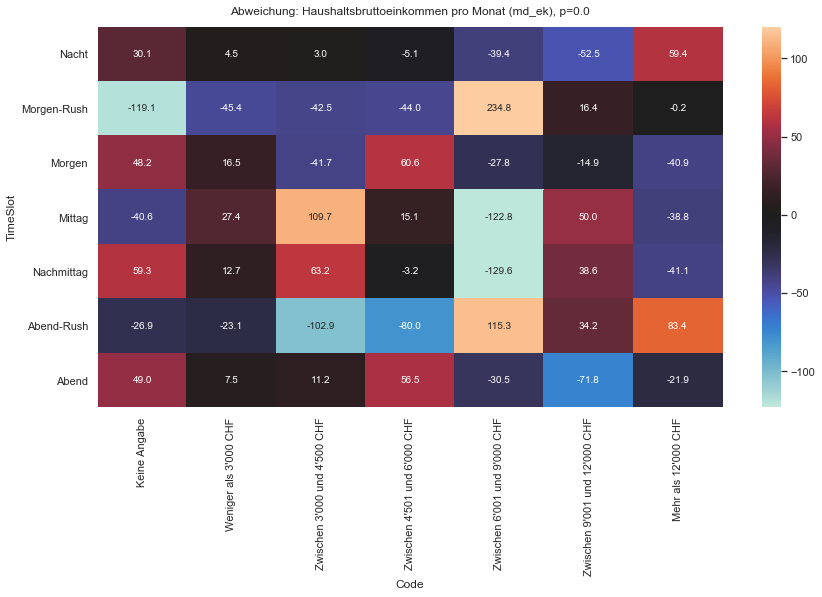

In [23]:
def _per_quarter(s):
    return s.sum() / s.size

def _extrapolate(s):
    return _per_quarter(s) * 4250 

show_code_cont_tables(
    selection=dict(
        DayOfWeek=workdays,
        Station="Lausanne",
        Variable=["md_ek"],
    ),
    index_by=["TimeSlot"],
    aggfunc="sum",
    show_chisq=True,
    chisq_resid="absolute",
)

## Estimate cell median and confidence intervals (quantiles)

In [ ]:
from scipy.stats import chi2_contingency


def var_factor_dependance(data, variable, factor, partitions):
    subset = data.loc[data.Variable == variable].pipe(clean_up_categoricals)
    result = pd.DataFrame(columns=["Var", "Label", f"p_{factor}"])
    for label, partition in subset.groupby(partitions, observed=True):
        result_row = {"Var": variable, "Label": label}
        contingency_tab = partition.pivot_table(
            index="Code", columns=factor, aggfunc="size", fill_value=0, observed=True
        )
        p_factor = chi2_contingency(contingency_tab)[1]
        result_row[f"p_{factor}"] = p_factor
        result = result.append(result_row, ignore_index=True, sort=False)
    return result

In [ ]:
def estimate(s):
    try:
        (q25, med, q75) = np.percentile(s, [25, 50, 75])
        iqr = q75 - q25
        #return [q25 - 1.5 * iqr, med, q75 + 1.5 * iqr]  # Tukey's outlier limits
        return [q25, med, q75]  # quartiles
    except:
        return -1

In [ ]:
selection = dict(
    #DayOfWeek=["Saturday", "Sunday"],
    Variable=["md_ek"],
    #Station=["Basel SBB", "Zürich HB"],
)

show_code_cont_tables(selection, index_by="TimeSlot", aggfunc=estimate)